In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForSequenceClassification , RobertaTokenizer, RobertaForSequenceClassification
from BertClassifier import BertClassifier
from RobertaClassifier import RobertaClassifier
from FunctionUtil import *

from tqdm import tqdm
import os


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv("./Steam_Reviews.csv")

dataset.head()

,review,voted_up
0,This was a scary game. I was like aaa and then...,True
1,[b] One of my closest friend who I play with s...,True
2,"Cool game, but super short. Only 10 min. \nNot...",True
3,That was pretty good. It got me on edge when t...,True
4,Not bad for a free game. It's about 15 min of ...,True


In [3]:
results_list = []


In [4]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = Tokenizer(nlp.vocab)

ici on traite la data afin de re recuperer just les information importante : par exemple suprimer les [b] dans le premier review

In [5]:
documents = []
import multiprocessing

max_processes = multiprocessing.cpu_count()

for doc in nlp.pipe([str(r) for r in dataset['review']] , n_process=max_processes-1, batch_size=1000):
    documents.append(' '.join([tok.lemma_ for tok in doc if not tok.is_stop and tok.is_alpha]))


In [6]:
cv = CountVectorizer(max_features = 1500)
x_Review = cv.fit_transform(documents).toarray()
y_Votes = [int(i) for i in dataset["voted_up"]]


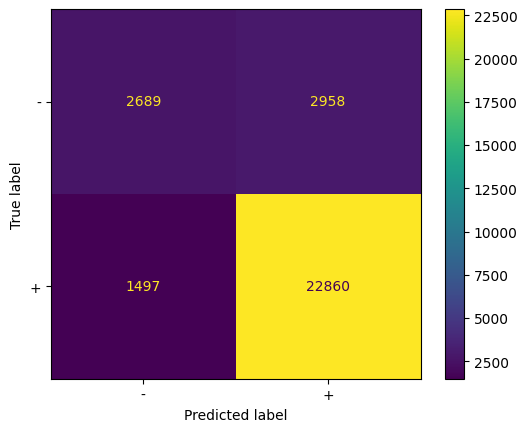

Precision per class:
 [0.64237936 0.88542877]
Recall per class:
 [0.47618204 0.93853923]
F1 Score per class:
 [0.54693379 0.91121076]
Weighted F1 Score: 0.8426508357186004


In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review, y_Votes, test_size=0.3)
classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)
metrics(test_labels, y_pred,'MultinomialNB Classic',results_list)

we now try to undersample the data to see if we can increase the precision and recall of the data 

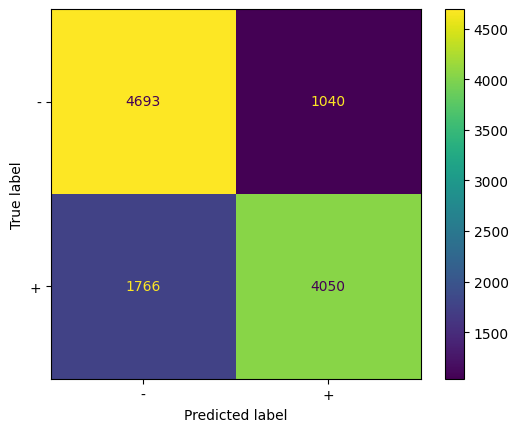

Precision per class:
 [0.72658306 0.7956778 ]
Recall per class:
 [0.8185941  0.69635488]
F1 Score per class:
 [0.76984908 0.74271043]
Weighted F1 Score: 0.7561822383957717


In [8]:
x_Review_undersampled , y_Votes_undersampled  = undersample_data(x_Review,y_Votes)
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review_undersampled, y_Votes_undersampled, test_size=0.3)

classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)

metrics(test_labels, y_pred,'MultinomialNB Undersampled',results_list)
 

Now we are going to try to Oversample to see if we are capable of increasing the precision of our modal 

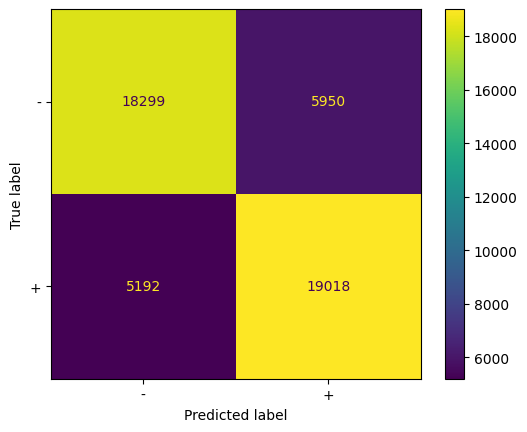

Precision per class:
 [0.77897918 0.76169497]
Recall per class:
 [0.75462906 0.78554316]
F1 Score per class:
 [0.76661081 0.77343528]
Weighted F1 Score: 0.7700202960618079


In [9]:
x_Review_oversampled , y_Votes_oversampled   = oversample_data(x_Review,y_Votes)
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review_oversampled, y_Votes_oversampled, test_size=0.3)

classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)

metrics(test_labels, y_pred,'MultinomialNB Oversampled',results_list )


In [10]:
Review = [str(i) for i in documents]
Votes = [int(i) for i in dataset["voted_up"]]
train_texts, test_texts, train_labels, test_labels = train_test_split(Review, Votes, test_size=0.3)

faire le data set classique


In [11]:
# model_name : 'bert-base-uncased'
classifier_bert = BertClassifier('./models/bert_model.pth')
classifier_bert.train(train_texts, train_labels)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading saved model...
Model loaded successfully.


In [12]:
all_labels, all_predictions = classifier_bert.evaluate(test_texts, test_labels)
classifier_bert.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_bert_model.csv')



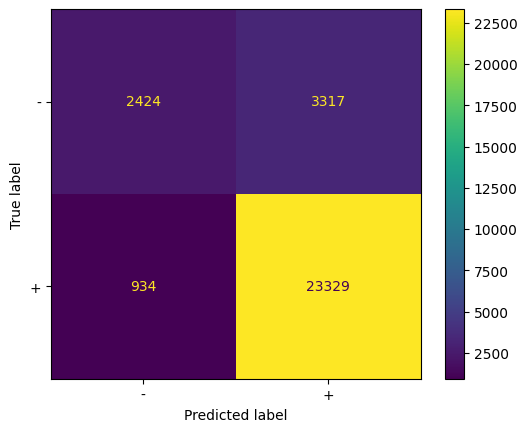

Precision per class:
 [0.72185825 0.87551602]
Recall per class:
 [0.42222609 0.96150517]
F1 Score per class:
 [0.5328058  0.91649807]
Weighted F1 Score: 0.8430819447214477


In [13]:
metrics(all_labels, all_predictions,'Bert',results_list )

undersampling the data to see the distribution of bert 

In [14]:
Review = np.array([str(i) for i in dataset["review"]])
Votes = np.array([int(i) for i in dataset["voted_up"]])

Review = Review.reshape(-1, 1)
Votes = Votes.reshape(-1, 1)

# Undersample the data using your function
review_undersampled, labels_unsampled = undersample_data(Review, Votes)


train_texts, test_texts, train_labels, test_labels = train_test_split(review_undersampled,labels_unsampled, test_size=0.3)

train_texts = train_texts.flatten()
test_texts = test_texts.flatten()



training the Undersampled model

In [15]:

classifier_bert_undersampled = BertClassifier('./models/bert_model_undersampled.pth')
classifier_bert_undersampled.train(train_texts, train_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading saved model...
Model loaded successfully.


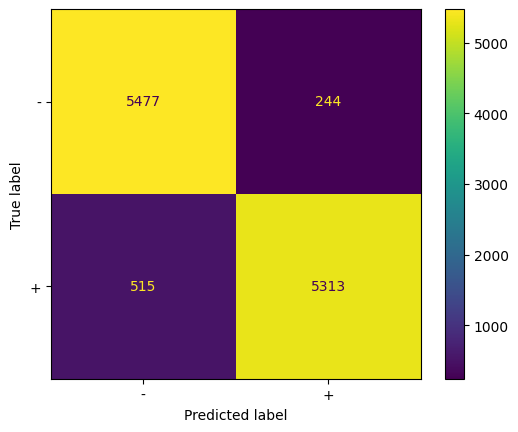

Precision per class:
 [0.91405207 0.95609142]
Recall per class:
 [0.95735011 0.91163349]
F1 Score per class:
 [0.9352002  0.93333333]
Weighted F1 Score: 0.9342581209544241


In [16]:
all_labels, all_predictions = classifier_bert_undersampled.evaluate(test_texts, test_labels)
classifier_bert_undersampled.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_bert_model_unsampled.csv')

metrics(all_labels, all_predictions,'Bert undersampled',results_list )


Now we are training Roberta Model to see if the results are better 

In [17]:
Review = [str(i) for i in dataset["review"]]
Votes = [int(i) for i in dataset["voted_up"]]

train_texts, test_texts, train_labels, test_labels = train_test_split(Review, Votes, test_size=0.3)



In [18]:
# model_name : 'RobertA_Model'
classifier_RobertA = RobertaClassifier('./models/RobertA_Model.pth')
classifier_RobertA.train(train_texts, train_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading saved model...
Model loaded successfully.


In [19]:
all_labels, all_predictions = classifier_RobertA.evaluate(test_texts, test_labels)
classifier_RobertA.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_Roberta_model.csv')



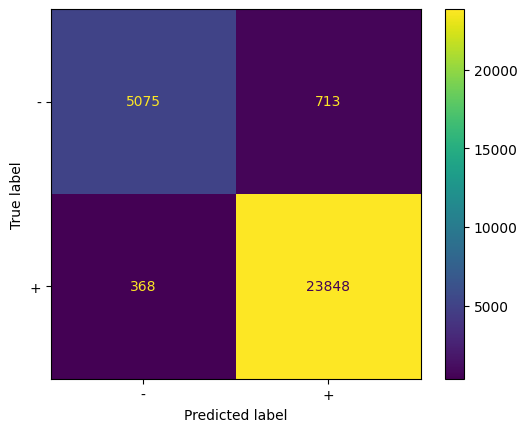

Precision per class:
 [0.93239023 0.97097024]
Recall per class:
 [0.8768141  0.98480344]
F1 Score per class:
 [0.90374855 0.97783792]
Weighted F1 Score: 0.9635455134316563


In [20]:
metrics(all_labels, all_predictions,'RobertA',results_list )


In [21]:
Review = np.array([str(i) for i in dataset["review"]])
Votes = np.array([int(i) for i in dataset["voted_up"]])

Review = Review.reshape(-1, 1)
Votes = Votes.reshape(-1, 1)

review_undersampled, labels_unsampled = undersample_data(Review, Votes)


train_texts, test_texts, train_labels, test_labels = train_test_split(review_undersampled,labels_unsampled, test_size=0.3)

train_texts = train_texts.flatten()
test_texts = test_texts.flatten()

In [22]:
classifier_RobertA_Undersampled = RobertaClassifier('./models/RobertA_Model_Undersampled.pth')
classifier_RobertA_Undersampled.train(train_texts, train_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading saved model...
Model loaded successfully.


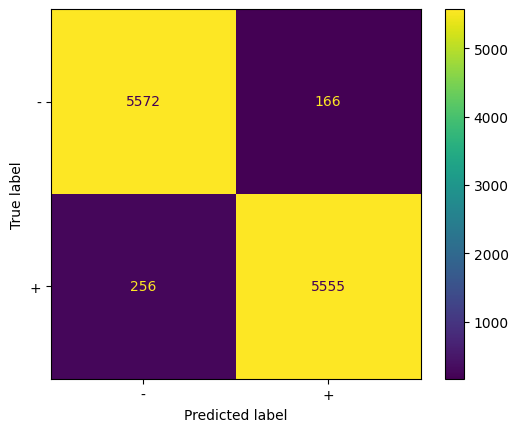

Precision per class:
 [0.95607412 0.97098409]
Recall per class:
 [0.97107006 0.95594562]
F1 Score per class:
 [0.96351375 0.96340617]
Weighted F1 Score: 0.9634596206781573


In [23]:
all_labels, all_predictions = classifier_RobertA_Undersampled.evaluate(test_texts, test_labels)
classifier_RobertA_Undersampled.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_Roberta_model_undersampled.csv')

metrics(all_labels, all_predictions,'RobertA Undersampled',results_list )

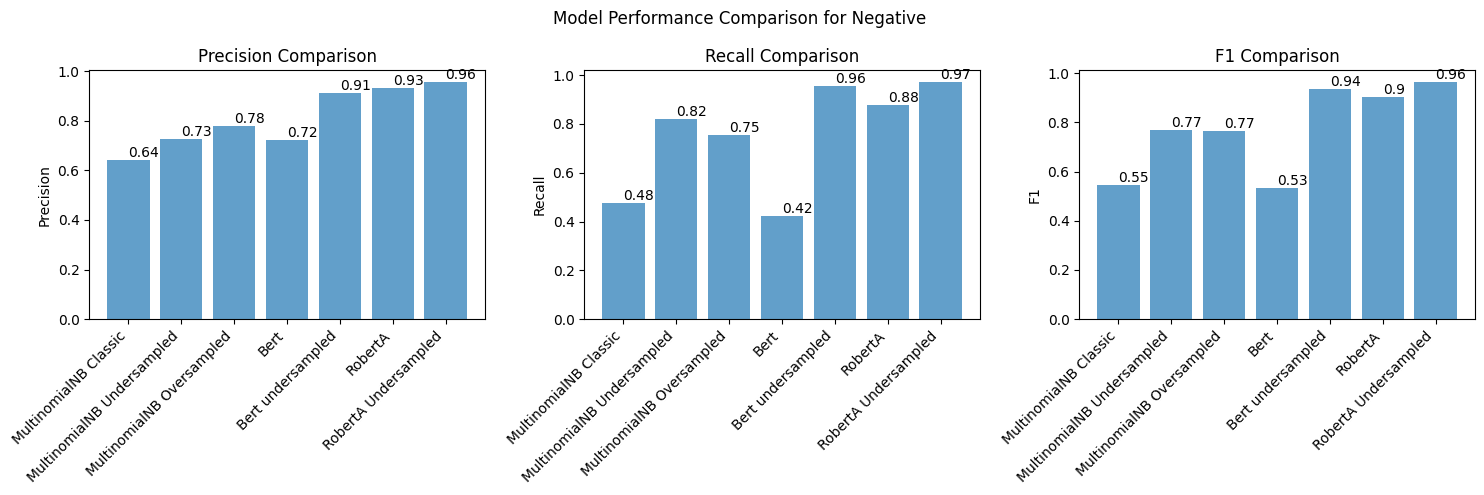

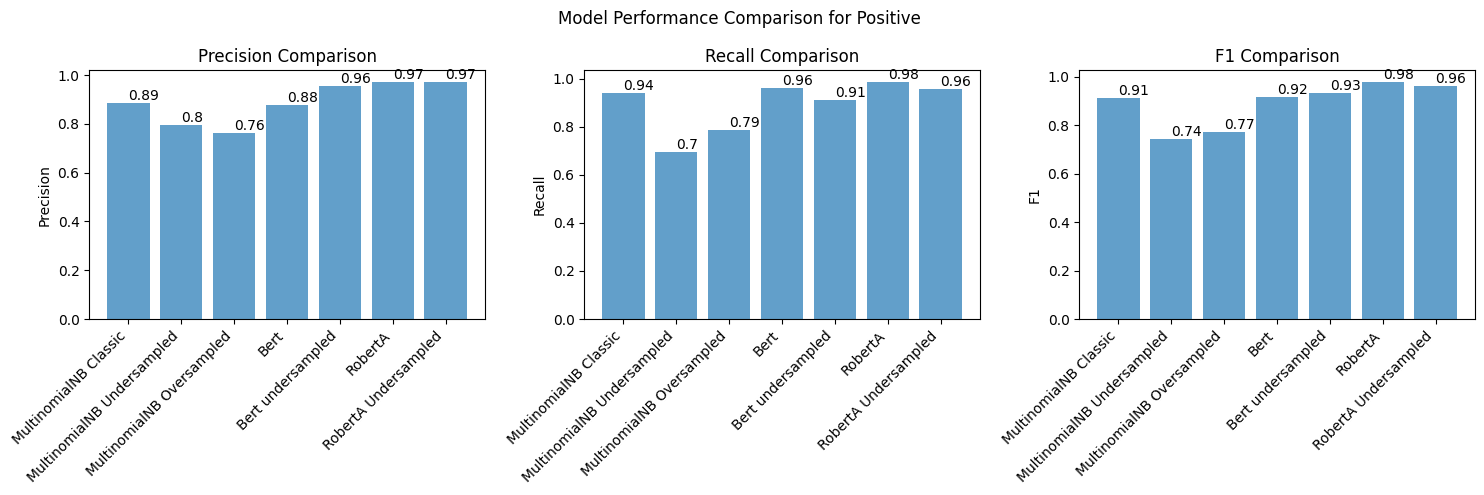

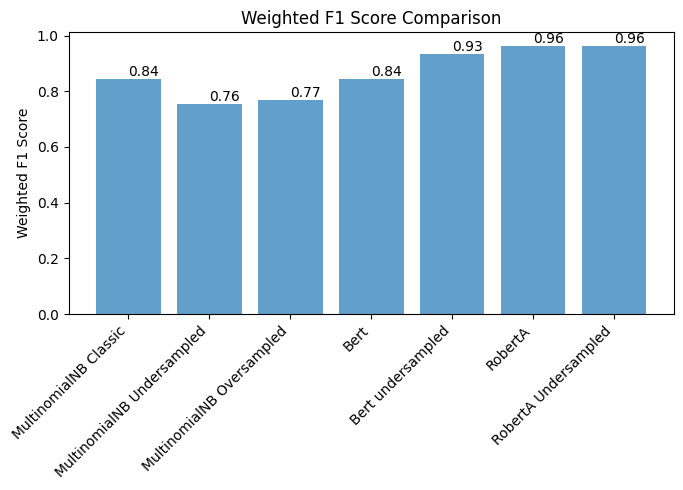

In [24]:
plot_model_comparisons(results_list)